<div class="warning" style='padding:0.1em; background-color:#E9D8FD; color:#69337A'>
<span>
<p style='margin-top:1em; text-align:center'>
<p style='margin-left:1em;'>

# Table of Contents <a class="anchor"  id="TOC"></a>
* [Installations](#installations)
* [Import Libraries](#importlib)
* [Tokenizers](#tokenizers)
    * [Autotokenizer](#autotokenizer)
        * [Muril Large Cased](#murillarge)
        * [Muril Base Cased](#murilbase)
        * [Indic BERT](#indicbert)
        * [Opus-mt-en-dra](#opus)
* [Custom Tokenizer Function](#customtoken)
* [Top2Vec](#top2vec)
* [Top2Vec in Tamil](#top2vec-tamil)
    * [Load Data](#loaddata)
    * [Parameters](#parameters)
        * [Embedding Model Paths](#embeddingmodels)
        * [UMAP and HDBSCAN parameters](#umaphdbscan)    
    * [Getting Topic Vectors](#topicveccall)
  
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> 
</p></span>
</div>

# Installations <a class="anchor"  id="installations"></a>
[Go Back to Table of Contents](#TOC)

In [1]:
!pip uninstall umap
!pip install umap-learn
!pip install gensim==4.2.0
!pip install joblib==1.1.0
# !pip install sentencepiece
!pip install hdbscan
!pip install transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 60.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.3 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.1.0 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but

# Import Libraries <a class="anchor"  id="importlib"></a>
[Go Back to Table of Contents](#TOC)

In [2]:
import logging
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags, strip_punctuation
from gensim.models.phrases import Phrases
import umap.umap_ as umap
import hdbscan
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.cluster import dbscan
import tempfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModel
from sentence_transformers import SentenceTransformer

try:
    import hnswlib

    _HAVE_HNSWLIB = True
except ImportError:
    _HAVE_HNSWLIB = False

try:
    import tensorflow as tf
    import tensorflow_hub as hub
    import tensorflow_text

    _HAVE_TENSORFLOW = True
except ImportError:
    _HAVE_TENSORFLOW = False

try:
    from sentence_transformers import SentenceTransformer

    _HAVE_TORCH = True
except ImportError:
    _HAVE_TORCH = False

logger = logging.getLogger('top2vec')
logger.setLevel(logging.WARNING)
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(sh)

## Tokenizers <a class="anchor"  id="tokenizers"></a>
[Go Back to Table of Contents](#TOC)

### Autotokenizer <a class="anchor"  id="autotokenizer"></a>
[Go Back to Table of Contents](#TOC)

#### Muril Base Cased <a class="anchor"  id="murilbase"></a>
[Go Back to Table of Contents](#TOC)

In [ ]:
# tokenizer1 = AutoTokenizer.from_pretrained("google/muril-base-cased")

#### Muril Large Cased <a class="anchor"  id="murillarge"></a>
[Go Back to Table of Contents](#TOC)

In [85]:
tokenizer1 = AutoTokenizer.from_pretrained("google/muril-large-cased")

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### Indic Bert <a class="anchor"  id="indicbert"></a>
[Go Back to Table of Contents](#TOC)

In [ ]:
# tokenizer1 = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

#### Opus-mt-en-dra <a class="anchor"  id="opus"></a>
[Go Back to Table of Contents](#TOC)

In [ ]:
# tokenizer1 = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-dra")

# Custom Tokenizer <a class="anchor"  id="customtoken"></a>
[Go Back to Table of Contents](#TOC)

In [86]:
def custom_tokenizer(d):
    """Tokenize a document for training and remove too long/short words

    Parameters
    ----------
    document: List of str
        Input document.

    Returns
    -------
    tokenized_document: List of str
        List of tokens.

    """
    tokens_list = []
    encoding = tokenizer1.encode(strip_punctuation(d))
    tokens = tokenizer1.convert_ids_to_tokens(encoding)
    # tokens_list.append(tokens[1:-1])
    results = []
    oldx = None
    for x in tokens[1:-1]:
        if x.startswith('#'):
            y = x.replace('#', '')
            # results.append(oldx+y)
            oldx = oldx+y
        else:
            if oldx == None:
                results.append(x)
            else:
                results.append(oldx)
            oldx = x
    return results

# Top2Vec <a class="anchor"  id="top2vec"></a>
[Go Back to Table of Contents](#TOC)

In [87]:
def default_tokenizer(document):
    """Tokenize a document for training and remove too long/short words
    Parameters
    ----------
    document: List of str
        Input document.
    Returns
    -------
    tokenized_document: List of str
        List of tokens.
    """
    return simple_preprocess(strip_tags(document), deacc=True)


def get_chunks(tokens, chunk_length, max_num_chunks, chunk_overlap_ratio):
    """Split a document into sequential chunks
    Parameters
    ----------
    tokens: List of str
        Input document tokens.
    chunk_length: int
        Length of each document chunk.
    max_num_chunks: int (Optional, default None)
        Limit the number of document chunks
    chunk_overlap_ratio: float
        Fraction of overlapping tokens between sequential chunks.
    Returns
    -------
    chunked_document: List of str
        List of document chunks.
    """
    num_tokens = len(tokens)
    if num_tokens == 0:
        return [""]

    num_chunks = int(np.ceil(num_tokens / chunk_length))

    if max_num_chunks is not None:
        num_chunks = min(num_chunks, max_num_chunks)

    return [" ".join(tokens[i:i + chunk_length])
            for i in list(range(0, num_tokens, int(chunk_length * (1 - chunk_overlap_ratio))))[0:num_chunks]]


def get_random_chunks(tokens, chunk_length, chunk_len_coverage_ratio, max_num_chunks):
    """Split a document into chunks starting at random positions
    Parameters
    ----------
    tokens: List of str
        Input document tokens.
    chunk_length: int
        Length of each document chunk.
    chunk_len_coverage_ratio: float
        Proportion of token length that will be covered by chunks. Default
        value of 1.0 means chunk lengths will add up to number of tokens.
        This does not mean all tokens will be covered.
    max_num_chunks: int (Optional, default None)
        Limit the number of document chunks
    Returns
    -------
    chunked_document: List of str
        List of document chunks.
    """
    num_tokens = len(tokens)
    if num_tokens == 0:
        return [""]

    num_chunks = int(np.ceil(num_tokens * chunk_len_coverage_ratio / chunk_length))

    if max_num_chunks is not None:
        num_chunks = min(num_chunks, max_num_chunks)

    starts = np.random.choice(range(0, num_tokens), size=num_chunks)
    return [" ".join(tokens[i:i + chunk_length]) for i in starts]


class Top2Vec:
    """
    Top2Vec
    Creates jointly embedded topic, document and word vectors.
    Parameters
    ----------
    documents: List of str
        Input corpus, should be a list of strings.
    min_count: int (Optional, default 50)
        Ignores all words with total frequency lower than this. For smaller
        corpora a smaller min_count will be necessary.
    ngram_vocab: bool (Optional, default False)
        Add phrases to topic descriptions.
        Uses gensim phrases to find common phrases in the corpus and adds them
        to the vocabulary.
        For more information visit:
        https://radimrehurek.com/gensim/models/phrases.html
    ngram_vocab_args: dict (Optional, default None)
        Pass custom arguments to gensim phrases.
        For more information visit:
        https://radimrehurek.com/gensim/models/phrases.html
    embedding_model: string or callable
        This will determine which model is used to generate the document and
        word embeddings. The valid string options are:
            * doc2vec
            * universal-sentence-encoder
            * universal-sentence-encoder-large
            * universal-sentence-encoder-multilingual
            * universal-sentence-encoder-multilingual-large
            * distiluse-base-multilingual-cased
            * all-MiniLM-L6-v2
            * paraphrase-multilingual-MiniLM-L12-v2
        For large data sets and data sets with very unique vocabulary doc2vec
        could produce better results. This will train a doc2vec model from
        scratch. This method is language agnostic. However multiple languages
        will not be aligned.
        Using the universal sentence encoder options will be much faster since
        those are pre-trained and efficient models. The universal sentence
        encoder options are suggested for smaller data sets. They are also
        good options for large data sets that are in English or in languages
        covered by the multilingual model. It is also suggested for data sets
        that are multilingual.
        For more information on universal-sentence-encoder options visit:
        https://tfhub.dev/google/collections/universal-sentence-encoder/1
        The SBERT pre-trained sentence transformer options are
        distiluse-base-multilingual-cased,
        paraphrase-multilingual-MiniLM-L12-v2, and all-MiniLM-L6-v2.
        The distiluse-base-multilingual-cased and
        paraphrase-multilingual-MiniLM-L12-v2 are suggested for multilingual
        datasets and languages that are not
        covered by the multilingual universal sentence encoder. The
        transformer is significantly slower than the universal sentence
        encoder options(except for the large options).
        For more information on SBERT options visit:
        https://www.sbert.net/docs/pretrained_models.html
        If passing a callable embedding_model note that it will not be saved
        when saving a top2vec model. After loading such a saved top2vec model
        the set_embedding_model method will need to be called and the same
        embedding_model callable used during training must be passed to it.
    embedding_model_path: string (Optional)
        Pre-trained embedding models will be downloaded automatically by
        default. However they can also be uploaded from a file that is in the
        location of embedding_model_path.
        Warning: the model at embedding_model_path must match the
        embedding_model parameter type.
    embedding_batch_size: int (default=32)
        Batch size for documents being embedded.
    split_documents: bool (default False)
        If set to True, documents will be split into parts before embedding.
        After embedding the multiple document part embeddings will be averaged
        to create a single embedding per document. This is useful when documents
        are very large or when the embedding model has a token limit.
        Document chunking or a senticizer can be used for document splitting.
    document_chunker: string or callable (default 'sequential')
        This will break the document into chunks. The valid string options are:
            * sequential
            * random
        The sequential chunker will split the document into chunks of specified
        length and ratio of overlap. This is the recommended method.
        The random chunking option will take random chunks of specified length
        from the document. These can overlap and should be thought of as
        sampling chunks with replacement from the document.
        If a callable is passed it must take as input a list of tokens of
        a document and return a list of strings representing the resulting
        document chunks.
        Only one of document_chunker or sentincizer should be used.
    chunk_length: int (default 100)
        The number of tokens per document chunk if using the document chunker
        string options.
    max_num_chunks: int (Optional)
        The maximum number of chunks generated per document if using the
        document chunker string options.
    chunk_overlap_ratio: float (default 0.5)
        Only applies to the 'sequential' document chunker.
        Fraction of overlapping tokens between sequential chunks. A value of
        0 will result i no overlap, where as 0.5 will overlap half of the
        previous chunk.
    chunk_len_coverage_ratio: float (default 1.0)
        Only applies to the 'random' document chunker option.
        Proportion of token length that will be covered by chunks. Default
        value of 1.0 means chunk lengths will add up to number of tokens of
        the document. This does not mean all tokens will be covered since
        chunks can be overlapping.
    sentencizer: callable (Optional)
        A sentincizer callable can be passed. The input should be a string
        representing the document and the output should be a list of strings
        representing the document sentence chunks.
        Only one of document_chunker or sentincizer should be used.
    speed: string (Optional, default 'learn')
        This parameter is only used when using doc2vec as embedding_model.
        It will determine how fast the model takes to train. The
        fast-learn option is the fastest and will generate the lowest quality
        vectors. The learn option will learn better quality vectors but take
        a longer time to train. The deep-learn option will learn the best
        quality vectors but will take significant time to train. The valid
        string speed options are:
        
            * fast-learn
            * learn
            * deep-learn
    use_corpus_file: bool (Optional, default False)
        This parameter is only used when using doc2vec as embedding_model.
        Setting use_corpus_file to True can sometimes provide speedup for
        large datasets when multiple worker threads are available. Documents
        are still passed to the model as a list of str, the model will create
        a temporary corpus file for training.
    document_ids: List of str, int (Optional)
        A unique value per document that will be used for referring to
        documents in search results. If ids are not given to the model, the
        index of each document in the original corpus will become the id.
    keep_documents: bool (Optional, default True)
        If set to False documents will only be used for training and not saved
        as part of the model. This will reduce model size. When using search
        functions only document ids will be returned, not the actual
        documents.
    workers: int (Optional)
        The amount of worker threads to be used in training the model. Larger
        amount will lead to faster training.
    
    tokenizer: callable (Optional, default None)
        Override the default tokenization method. If None then
        gensim.utils.simple_preprocess will be used.
        Tokenizer must take a document and return a list of tokens.
    use_embedding_model_tokenizer: bool (Optional, default False)
        If using an embedding model other than doc2vec, use the model's
        tokenizer for document embedding. If set to True the tokenizer, either
        default or passed callable will be used to tokenize the text to
        extract the vocabulary for word embedding.
    umap_args: dict (Optional, default None)
        Pass custom arguments to UMAP.
    hdbscan_args: dict (Optional, default None)
        Pass custom arguments to HDBSCAN.
    
    verbose: bool (Optional, default True)
        Whether to print status data during training.
    """

    def __init__(self,
                 documents,
                 min_count=50,
                 ngram_vocab=False,
                 ngram_vocab_args=None,
                 embedding_model='doc2vec',
                 embedding_model_path=None,
                 embedding_batch_size=32,
                 split_documents=False,
                 document_chunker='sequential',
                 chunk_length=100,
                 max_num_chunks=None,
                 chunk_overlap_ratio=0.5,
                 chunk_len_coverage_ratio=1.0,
                 sentencizer=None,
                 speed='learn',
                 use_corpus_file=False,
                 document_ids=None,
                 keep_documents=True,
                 workers=None,
                 tokenizer=None,
                 use_embedding_model_tokenizer=False,
                 umap_args=None,
                 hdbscan_args=None,
                 verbose=True
                 ):

        if verbose:
            logger.setLevel(logging.DEBUG)
            self.verbose = True
        else:
            logger.setLevel(logging.WARNING)
            self.verbose = False

        if tokenizer is None:
            tokenizer = default_tokenizer

        # validate documents
        if not (isinstance(documents, list) or isinstance(documents, np.ndarray)):
            raise ValueError("Documents need to be a list of strings")
        if not all((isinstance(doc, str) or isinstance(doc, np.str_)) for doc in documents):
            raise ValueError("Documents need to be a list of strings")
        if keep_documents:
            self.documents = np.array(documents, dtype="object")
        else:
            self.documents = None

        # validate document ids
        if document_ids is not None:
            if not (isinstance(document_ids, list) or isinstance(document_ids, np.ndarray)):
                raise ValueError("Documents ids need to be a list of str or int")

            if len(documents) != len(document_ids):
                raise ValueError("Document ids need to match number of documents")
            elif len(document_ids) != len(set(document_ids)):
                raise ValueError("Document ids need to be unique")

            if all((isinstance(doc_id, str) or isinstance(doc_id, np.str_)) for doc_id in document_ids):
                self.doc_id_type = np.str_
            elif all((isinstance(doc_id, int) or isinstance(doc_id, np.int_)) for doc_id in document_ids):
                self.doc_id_type = np.int_
            else:
                raise ValueError("Document ids need to be str or int")

            self.document_ids_provided = True
            self.document_ids = np.array(document_ids)
            self.doc_id2index = dict(zip(document_ids, list(range(0, len(document_ids)))))
        else:
            self.document_ids_provided = False
            self.document_ids = np.array(range(0, len(documents)))
            self.doc_id2index = dict(zip(self.document_ids, list(range(0, len(self.document_ids)))))
            self.doc_id_type = np.int_

        self.embedding_model_path = embedding_model_path

        # validate document splitting
        use_sentencizer = False
        custom_chunker = False
        if split_documents:
            if document_chunker == 'sequential':
                document_chunker = get_chunks
                document_chunker_args = {"chunk_length": chunk_length,
                                         "max_num_chunks": max_num_chunks,
                                         "chunk_overlap_ratio": chunk_overlap_ratio}

            elif document_chunker == 'random':
                document_chunker = get_random_chunks
                document_chunker_args = {"chunk_length": chunk_length,
                                         "max_num_chunks": max_num_chunks,
                                         "chunk_len_coverage_ratio": chunk_len_coverage_ratio}

            elif callable(document_chunker):
                custom_chunker = True
            elif sentencizer is None:
                raise ValueError(f"{document_chunker} is an invalid document chunker.")
            elif callable(sentencizer):
                use_sentencizer = True
            else:
                raise ValueError(f"{sentencizer} is invalid. Document sentencizer must be callable.")

        if embedding_model == 'doc2vec':

            # validate training inputs
            if speed == "fast-learn":
                hs = 0
                negative = 5
                epochs = 40
            elif speed == "learn":
                hs = 1
                negative = 0
                epochs = 40
            elif speed == "deep-learn":
                hs = 1
                negative = 0
                epochs = 400
            elif speed == "test-learn":
                hs = 0
                negative = 5
                epochs = 1
            else:
                raise ValueError("speed parameter needs to be one of: fast-learn, learn or deep-learn")

            if workers is None:
                pass
            elif isinstance(workers, int):
                pass
            else:
                raise ValueError("workers needs to be an int")

            doc2vec_args = {"vector_size": 300,
                            "min_count": min_count,
                            "window": 15,
                            "sample": 1e-5,
                            "negative": negative,
                            "hs": hs,
                            "epochs": epochs,
                            "dm": 0,
                            "dbow_words": 1}

            if workers is not None:
                doc2vec_args["workers"] = workers

            logger.info('Pre-processing documents for training')

            if use_corpus_file:
                processed = [' '.join(tokenizer(doc)) for doc in documents]
                lines = "\n".join(processed)
                temp = tempfile.NamedTemporaryFile(mode='w+t')
                temp.write(lines)
                doc2vec_args["corpus_file"] = temp.name

            else:
                train_corpus = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(documents)]
                doc2vec_args["documents"] = train_corpus

            logger.info('Creating joint document/word embedding')
            self.embedding_model = 'doc2vec'
            self.model = Doc2Vec(**doc2vec_args)

            self.word_vectors = self.model.wv.get_normed_vectors()
            self.word_indexes = self.model.wv.key_to_index
            self.vocab = list(self.model.wv.key_to_index.keys())
            self.document_vectors = self.model.dv.get_normed_vectors()

            if ngram_vocab:
                tokenized_corpus = [tokenizer(doc) for doc in documents]

                if ngram_vocab_args is None:
                    ngram_vocab_args = {'sentences': tokenized_corpus,
                                        'min_count': 5,
                                        'threshold': 10.0,
                                        'delimiter': ' '}
                else:
                    ngram_vocab_args['sentences'] = tokenized_corpus
                    ngram_vocab_args['delimiter'] = ' '

                phrase_model = Phrases(**ngram_vocab_args)
                phrase_results = phrase_model.find_phrases(tokenized_corpus)
                phrases = list(phrase_results.keys())

                phrases_processed = [tokenizer(phrase) for phrase in phrases]
                phrase_vectors = np.vstack([self.model.infer_vector(doc_words=phrase,
                                                                    alpha=0.025,
                                                                    min_alpha=0.01,
                                                                    epochs=100) for phrase in phrases_processed])
                phrase_vectors = self._l2_normalize(phrase_vectors)

                self.word_vectors = np.vstack([self.word_vectors, phrase_vectors])
                self.vocab = self.vocab + phrases
                self.word_indexes = dict(zip(self.vocab, range(len(self.vocab))))

            if use_corpus_file:
                temp.close()

        elif (embedding_model in acceptable_embedding_models) or callable(embedding_model):

            self.embed = None
            self.embedding_model = embedding_model

            self._check_import_status()

            logger.info('Pre-processing documents for training')

            # preprocess documents
            tokenized_corpus = [tokenizer(doc) for doc in documents]

            def return_doc(doc):
                return doc

            # preprocess vocabulary
            vectorizer = CountVectorizer(tokenizer=return_doc, preprocessor=return_doc)
            doc_word_counts = vectorizer.fit_transform(tokenized_corpus)
            words = vectorizer.get_feature_names()
            word_counts = np.array(np.sum(doc_word_counts, axis=0).tolist()[0])
            vocab_inds = np.where(word_counts > min_count)[0]

            if len(vocab_inds) == 0:
                raise ValueError(f"A min_count of {min_count} results in "
                                 f"all words being ignored, choose a lower value.")
            self.vocab = [words[ind] for ind in vocab_inds]

            if ngram_vocab:
                if ngram_vocab_args is None:
                    ngram_vocab_args = {'sentences': tokenized_corpus,
                                        'min_count': 5,
                                        'threshold': 10.0,
                                        'delimiter': ' '}
                else:
                    ngram_vocab_args['sentences'] = tokenized_corpus
                    ngram_vocab_args['delimiter'] = ' '

                phrase_model = Phrases(**ngram_vocab_args)
                phrase_results = phrase_model.find_phrases(tokenized_corpus)
                phrases = list(phrase_results.keys())

                self.vocab = self.vocab + phrases

            self._check_model_status()

            logger.info('Creating joint document/word embedding')

            # embed words
            self.word_indexes = dict(zip(self.vocab, range(len(self.vocab))))
            self.word_vectors = self._l2_normalize(np.array(self.embed(self.vocab)))

            # embed documents

            # split documents
            if split_documents:
                if use_sentencizer:
                    chunk_id = 0
                    chunked_docs = []
                    chunked_doc_ids = []
                    for doc in documents:
                        doc_chunks = sentencizer(doc)
                        doc_chunk_ids = [chunk_id] * len(doc_chunks)
                        chunk_id += 1
                        chunked_docs.extend(doc_chunks)
                        chunked_doc_ids.extend(doc_chunk_ids)

                else:
                    chunk_id = 0
                    chunked_docs = []
                    chunked_doc_ids = []
                    for tokens in tokenized_corpus:
                        if custom_chunker:
                            doc_chunks = document_chunker(tokens)
                        else:
                            doc_chunks = document_chunker(tokens, **document_chunker_args)
                        doc_chunk_ids = [chunk_id] * len(doc_chunks)
                        chunk_id += 1
                        chunked_docs.extend(doc_chunks)
                        chunked_doc_ids.extend(doc_chunk_ids)

                chunked_doc_ids = np.array(chunked_doc_ids)
                document_chunk_vectors = self._embed_documents(chunked_docs, embedding_batch_size)
                self.document_vectors = self._l2_normalize(
                    np.vstack([document_chunk_vectors[np.where(chunked_doc_ids == label)[0]]
                              .mean(axis=0) for label in set(chunked_doc_ids)]))

            # original documents
            else:
                if use_embedding_model_tokenizer:
                    self.document_vectors = self._embed_documents(documents, embedding_batch_size)
                else:
                    train_corpus = [' '.join(tokens) for tokens in tokenized_corpus]
                    self.document_vectors = self._embed_documents(train_corpus, embedding_batch_size)

        else:
            raise ValueError(f"{embedding_model} is an invalid embedding model.")

        # create 5D embeddings of documents
        logger.info('Creating lower dimension embedding of documents')

        if umap_args is None:
            umap_args = {'n_neighbors': 15,
                         'n_components': 5,
                         'metric': 'cosine'}

        umap_model = umap.UMAP(**umap_args).fit(self.document_vectors)

        # find dense areas of document vectors
        logger.info('Finding dense areas of documents')

        if hdbscan_args is None:
            hdbscan_args = {'min_cluster_size': 15,
                            'metric': 'euclidean',
                            'cluster_selection_method': 'eom'}

        cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

        # calculate topic vectors from dense areas of documents
        logger.info('Finding topics')

        # create topic vectors
        self._create_topic_vectors(cluster.labels_)

        # deduplicate topics
        self._deduplicate_topics()

        # find topic words and scores
        self.topic_words, self.topic_word_scores = self._find_topic_words_and_scores(topic_vectors=self.topic_vectors)

        # assign documents to topic
        self.doc_top, self.doc_dist = self._calculate_documents_topic(self.topic_vectors,
                                                                      self.document_vectors)

        # calculate topic sizes
        self.topic_sizes = self._calculate_topic_sizes(hierarchy=False)

        # re-order topics
        self._reorder_topics(hierarchy=False)

        # initialize variables for hierarchical topic reduction
        self.topic_vectors_reduced = None
        self.doc_top_reduced = None
        self.doc_dist_reduced = None
        self.topic_sizes_reduced = None
        self.topic_words_reduced = None
        self.topic_word_scores_reduced = None
        self.hierarchy = None

        # initialize document indexing variables
        self.document_index = None
        self.serialized_document_index = None
        self.documents_indexed = False
        self.index_id2doc_id = None
        self.doc_id2index_id = None

        # initialize word indexing variables
        self.word_index = None
        self.serialized_word_index = None
        self.words_indexed = False

    def save(self, file):
        """
        Saves the current model to the specified file.
        Parameters
        ----------
        file: str
            File where model will be saved.
        """

        document_index_temp = None
        word_index_temp = None

        # do not save sentence encoders, sentence transformers and custom embedding
        if self.embedding_model not in ["doc2vec"]:
            self.embed = None

        # serialize document index so that it can be saved
        if self.documents_indexed:
            temp = tempfile.NamedTemporaryFile(mode='w+b')
            self.document_index.save_index(temp.name)
            self.serialized_document_index = temp.read()
            temp.close()
            document_index_temp = self.document_index
            self.document_index = None

        # serialize word index so that it can be saved
        if self.words_indexed:
            temp = tempfile.NamedTemporaryFile(mode='w+b')
            self.word_index.save_index(temp.name)
            self.serialized_word_index = temp.read()
            temp.close()
            word_index_temp = self.word_index
            self.word_index = None

        dump(self, file)

        self.document_index = document_index_temp
        self.word_index = word_index_temp

    @classmethod
    def load(cls, file):
        """
        Load a pre-trained model from the specified file.
        Parameters
        ----------
        file: str
            File where model will be loaded from.
        """

        top2vec_model = load(file)

        # load document index
        if top2vec_model.documents_indexed:
            if not _HAVE_HNSWLIB:
                raise ImportError(f"Cannot load document index.\n\n"
                                  "Try: pip install top2vec[indexing]\n\n"
                                  "Alternatively try: pip install hnswlib")

            temp = tempfile.NamedTemporaryFile(mode='w+b')
            temp.write(top2vec_model.serialized_document_index)
            document_vectors = top2vec_model.document_vectors
            top2vec_model.document_index = hnswlib.Index(space='ip',
                                                         dim=document_vectors.shape[1])
            top2vec_model.document_index.load_index(temp.name, max_elements=document_vectors.shape[0])
            temp.close()
            top2vec_model.serialized_document_index = None

        # load word index
        if top2vec_model.words_indexed:

            if not _HAVE_HNSWLIB:
                raise ImportError(f"Cannot load word index.\n\n"
                                  "Try: pip install top2vec[indexing]\n\n"
                                  "Alternatively try: pip install hnswlib")

            temp = tempfile.NamedTemporaryFile(mode='w+b')
            temp.write(top2vec_model.serialized_word_index)
            word_vectors = top2vec_model.word_vectors
            top2vec_model.word_index = hnswlib.Index(space='ip',
                                                     dim=word_vectors.shape[1])
            top2vec_model.word_index.load_index(temp.name, max_elements=word_vectors.shape[0])
            temp.close()
            top2vec_model.serialized_word_index = None

        return top2vec_model

    @staticmethod
    def _l2_normalize(vectors):

        if vectors.ndim == 2:
            return normalize(vectors)
        else:
            return normalize(vectors.reshape(1, -1))[0]

    def _embed_documents(self, train_corpus, batch_size):

        self._check_import_status()
        self._check_model_status()

        # embed documents
        document_vectors = []

        if (self.embedding_model in use_models) or self.embedding_model == "custom":

            current = 0
            batches = int(len(train_corpus) / batch_size)
            extra = len(train_corpus) % batch_size

            for ind in range(0, batches):
                document_vectors.append(self.embed(train_corpus[current:current + batch_size]))
                current += batch_size

            if extra > 0:
                document_vectors.append(self.embed(train_corpus[current:current + extra]))

            document_vectors = self._l2_normalize(np.array(np.vstack(document_vectors)))

        else:
            document_vectors = self.embed(train_corpus, batch_size=batch_size)

        return document_vectors

    def _embed_query(self, query):
        self._check_import_status()
        self._check_model_status()

        return self._l2_normalize(np.array(self.embed([query])[0]))

    def _create_topic_vectors(self, cluster_labels):
        unique_labels = set(cluster_labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        self.topic_vectors = self._l2_normalize(
            np.vstack([self.document_vectors[np.where(cluster_labels == label)[0]]
                      .mean(axis=0) for label in unique_labels]))

    def _deduplicate_topics(self):
        core_samples, labels = dbscan(X=self.topic_vectors,
                                      eps=0.1,
                                      min_samples=2,
                                      metric="cosine")

        duplicate_clusters = set(labels)

        if len(duplicate_clusters) > 1 or -1 not in duplicate_clusters:

            # unique topics
            unique_topics = self.topic_vectors[np.where(labels == -1)[0]]

            if -1 in duplicate_clusters:
                duplicate_clusters.remove(-1)

            # merge duplicate topics
            for unique_label in duplicate_clusters:
                unique_topics = np.vstack(
                    [unique_topics, self._l2_normalize(self.topic_vectors[np.where(labels == unique_label)[0]]
                                                       .mean(axis=0))])

            self.topic_vectors = unique_topics

    def _calculate_topic_sizes(self, hierarchy=False):
        if hierarchy:
            topic_sizes = pd.Series(self.doc_top_reduced).value_counts()
        else:
            topic_sizes = pd.Series(self.doc_top).value_counts()

        return topic_sizes

    def _reorder_topics(self, hierarchy=False):

        if hierarchy:
            self.topic_vectors_reduced = self.topic_vectors_reduced[self.topic_sizes_reduced.index]
            self.topic_words_reduced = self.topic_words_reduced[self.topic_sizes_reduced.index]
            self.topic_word_scores_reduced = self.topic_word_scores_reduced[self.topic_sizes_reduced.index]
            old2new = dict(zip(self.topic_sizes_reduced.index, range(self.topic_sizes_reduced.index.shape[0])))
            self.doc_top_reduced = np.array([old2new[i] for i in self.doc_top_reduced])
            self.hierarchy = [self.hierarchy[i] for i in self.topic_sizes_reduced.index]
            self.topic_sizes_reduced.reset_index(drop=True, inplace=True)
        else:
            self.topic_vectors = self.topic_vectors[self.topic_sizes.index]
            self.topic_words = self.topic_words[self.topic_sizes.index]
            self.topic_word_scores = self.topic_word_scores[self.topic_sizes.index]
            old2new = dict(zip(self.topic_sizes.index, range(self.topic_sizes.index.shape[0])))
            self.doc_top = np.array([old2new[i] for i in self.doc_top])
            self.topic_sizes.reset_index(drop=True, inplace=True)

    @staticmethod
    def _calculate_documents_topic(topic_vectors, document_vectors, dist=True, num_topics=None):
        batch_size = 10000
        doc_top = []
        if dist:
            doc_dist = []

        if document_vectors.shape[0] > batch_size:
            current = 0
            batches = int(document_vectors.shape[0] / batch_size)
            extra = document_vectors.shape[0] % batch_size

            for ind in range(0, batches):
                res = np.inner(document_vectors[current:current + batch_size], topic_vectors)

                if num_topics is None:
                    doc_top.extend(np.argmax(res, axis=1))
                    if dist:
                        doc_dist.extend(np.max(res, axis=1))
                else:
                    doc_top.extend(np.flip(np.argsort(res), axis=1)[:, :num_topics])
                    if dist:
                        doc_dist.extend(np.flip(np.sort(res), axis=1)[:, :num_topics])

                current += batch_size

            if extra > 0:
                res = np.inner(document_vectors[current:current + extra], topic_vectors)

                if num_topics is None:
                    doc_top.extend(np.argmax(res, axis=1))
                    if dist:
                        doc_dist.extend(np.max(res, axis=1))
                else:
                    doc_top.extend(np.flip(np.argsort(res), axis=1)[:, :num_topics])
                    if dist:
                        doc_dist.extend(np.flip(np.sort(res), axis=1)[:, :num_topics])
            if dist:
                doc_dist = np.array(doc_dist)
        else:
            res = np.inner(document_vectors, topic_vectors)

            if num_topics is None:
                doc_top = np.argmax(res, axis=1)
                if dist:
                    doc_dist = np.max(res, axis=1)
            else:
                doc_top.extend(np.flip(np.argsort(res), axis=1)[:, :num_topics])
                if dist:
                    doc_dist.extend(np.flip(np.sort(res), axis=1)[:, :num_topics])

        if num_topics is not None:
            doc_top = np.array(doc_top)
            if dist:
                doc_dist = np.array(doc_dist)

        if dist:
            return doc_top, doc_dist
        else:
            return doc_top

    def _find_topic_words_and_scores(self, topic_vectors):
        topic_words = []
        topic_word_scores = []

        res = np.inner(topic_vectors, self.word_vectors)
        top_words = np.flip(np.argsort(res, axis=1), axis=1)
        top_scores = np.flip(np.sort(res, axis=1), axis=1)

        for words, scores in zip(top_words, top_scores):
            topic_words.append([self.vocab[i] for i in words[0:50]])
            topic_word_scores.append(scores[0:50])

        topic_words = np.array(topic_words)
        topic_word_scores = np.array(topic_word_scores)

        return topic_words, topic_word_scores

    def _assign_documents_to_topic(self, document_vectors, hierarchy=False):

        if hierarchy:
            doc_top_new, doc_dist_new = self._calculate_documents_topic(self.topic_vectors_reduced,
                                                                        document_vectors,
                                                                        dist=True)

            self.doc_top_reduced = np.array(list(self.doc_top_reduced) + list(doc_top_new))
            self.doc_dist_reduced = np.array(list(self.doc_dist_reduced) + list(doc_dist_new))

            topic_sizes_new = pd.Series(doc_top_new).value_counts()
            for top in topic_sizes_new.index.tolist():
                self.topic_sizes_reduced[top] += topic_sizes_new[top]
            self.topic_sizes_reduced.sort_values(ascending=False, inplace=True)
            self._reorder_topics(hierarchy)
        else:
            doc_top_new, doc_dist_new = self._calculate_documents_topic(self.topic_vectors, document_vectors, dist=True)
            self.doc_top = np.array(list(self.doc_top) + list(doc_top_new))
            self.doc_dist = np.array(list(self.doc_dist) + list(doc_dist_new))

            topic_sizes_new = pd.Series(doc_top_new).value_counts()
            for top in topic_sizes_new.index.tolist():
                self.topic_sizes[top] += topic_sizes_new[top]
            self.topic_sizes.sort_values(ascending=False, inplace=True)
            self._reorder_topics(hierarchy)

    def _unassign_documents_from_topic(self, doc_indexes, hierarchy=False):
        if hierarchy:
            doc_top_remove = self.doc_top_reduced[doc_indexes]
            self.doc_top_reduced = np.delete(self.doc_top_reduced, doc_indexes, 0)
            self.doc_dist_reduced = np.delete(self.doc_dist_reduced, doc_indexes, 0)
            topic_sizes_remove = pd.Series(doc_top_remove).value_counts()
            for top in topic_sizes_remove.index.tolist():
                self.topic_sizes_reduced[top] -= topic_sizes_remove[top]
            self.topic_sizes_reduced.sort_values(ascending=False, inplace=True)
            self._reorder_topics(hierarchy)
        else:
            doc_top_remove = self.doc_top[doc_indexes]
            self.doc_top = np.delete(self.doc_top, doc_indexes, 0)
            self.doc_dist = np.delete(self.doc_dist, doc_indexes, 0)
            topic_sizes_remove = pd.Series(doc_top_remove).value_counts()
            for top in topic_sizes_remove.index.tolist():
                self.topic_sizes[top] -= topic_sizes_remove[top]
            self.topic_sizes.sort_values(ascending=False, inplace=True)
            self._reorder_topics(hierarchy)

    def _get_document_ids(self, doc_index):
        return self.document_ids[doc_index]

    def _get_document_indexes(self, doc_ids):
        if self.document_ids is None:
            return doc_ids
        else:
            return [self.doc_id2index[doc_id] for doc_id in doc_ids]

    def _words2word_vectors(self, keywords):

        return self.word_vectors[[self.word_indexes[word] for word in keywords]]

    def _get_combined_vec(self, vecs, vecs_neg):

        combined_vector = np.zeros(self.document_vectors.shape[1], dtype=np.float64)
        for vec in vecs:
            combined_vector += vec
        for vec in vecs_neg:
            combined_vector -= vec
        combined_vector /= (len(vecs) + len(vecs_neg))
        combined_vector = self._l2_normalize(combined_vector)

        return combined_vector

    @staticmethod
    def _search_vectors_by_vector(vectors, vector, num_res):
        ranks = np.inner(vectors, vector)
        indexes = np.flip(np.argsort(ranks)[-num_res:])
        scores = np.array([ranks[res] for res in indexes])

        return indexes, scores

    @staticmethod
    def _check_hnswlib_status():
        if not _HAVE_HNSWLIB:
            raise ImportError(f"Indexing is not available.\n\n"
                              "Try: pip install top2vec[indexing]\n\n"
                              "Alternatively try: pip install hnswlib")

    def _check_document_index_status(self):
        if self.document_index is None:
            raise ImportError("There is no document index.\n\n"
                              "Call index_document_vectors method before setting use_index=True.")

    def _check_word_index_status(self):
        if self.word_index is None:
            raise ImportError("There is no word index.\n\n"
                              "Call index_word_vectors method before setting use_index=True.")

    def _check_import_status(self):
        if self.embedding_model in use_models:
            if not _HAVE_TENSORFLOW:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_encoders]\n\n"
                                  "Alternatively try: pip install tensorflow tensorflow_hub tensorflow_text")
        elif self.embedding_model in sbert_models:
            if not _HAVE_TORCH:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_transformers]\n\n"
                                  "Alternatively try: pip install torch sentence_transformers")

    def _check_model_status(self):
        if self.embed is None:
            if self.verbose is False:
                logger.setLevel(logging.DEBUG)

            if self.embedding_model in use_models:
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    module = use_model_urls[self.embedding_model]

                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                self.embed = hub.load(module)

            elif self.embedding_model in sbert_models:
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    module = self.embedding_model
                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                model = SentenceTransformer(module)
                self.embed = model.encode

            elif callable(self.embedding_model):
                self.embed = self.embedding_model
                self.embedding_model = "custom"

            elif self.embedding_model == "custom":
                raise ValueError("Call set_embedding_model method and pass callable"
                                 " embedding_model used during training.")

        if self.verbose is False:
            logger.setLevel(logging.WARNING)

    @staticmethod
    def _less_than_zero(num, var_name):
        if num < 0:
            raise ValueError(f"{var_name} cannot be less than 0.")

    def _validate_hierarchical_reduction(self):
        if self.hierarchy is None:
            raise ValueError("Hierarchical topic reduction has not been performed.")

    def _validate_hierarchical_reduction_num_topics(self, num_topics):
        current_num_topics = len(self.topic_vectors)
        if num_topics >= current_num_topics:
            raise ValueError(f"Number of topics must be less than {current_num_topics}.")

    def _validate_num_docs(self, num_docs):
        self._less_than_zero(num_docs, "num_docs")
        document_count = len(self.doc_top)
        if num_docs > document_count:
            raise ValueError(f"num_docs cannot exceed the number of documents: {document_count}.")

    def _validate_num_topics(self, num_topics, reduced):
        self._less_than_zero(num_topics, "num_topics")
        if reduced:
            topic_count = len(self.topic_vectors_reduced)
            if num_topics > topic_count:
                raise ValueError(f"num_topics cannot exceed the number of reduced topics: {topic_count}.")
        else:
            topic_count = len(self.topic_vectors)
            if num_topics > topic_count:
                raise ValueError(f"num_topics cannot exceed the number of topics: {topic_count}.")

    def _validate_topic_num(self, topic_num, reduced):
        self._less_than_zero(topic_num, "topic_num")

        if reduced:
            topic_count = len(self.topic_vectors_reduced) - 1
            if topic_num > topic_count:
                raise ValueError(f"Invalid topic number: valid reduced topics numbers are 0 to {topic_count}.")
        else:
            topic_count = len(self.topic_vectors) - 1
            if topic_num > topic_count:
                raise ValueError(f"Invalid topic number: valid original topics numbers are 0 to {topic_count}.")

    def _validate_topic_search(self, topic_num, num_docs, reduced):
        self._less_than_zero(num_docs, "num_docs")
        if reduced:
            if num_docs > self.topic_sizes_reduced[topic_num]:
                raise ValueError(f"Invalid number of documents: reduced topic {topic_num}"
                                 f" only has {self.topic_sizes_reduced[topic_num]} documents.")
        else:
            if num_docs > self.topic_sizes[topic_num]:
                raise ValueError(f"Invalid number of documents: original topic {topic_num}"
                                 f" only has {self.topic_sizes[topic_num]} documents.")

    def _validate_doc_ids(self, doc_ids, doc_ids_neg):

        if not (isinstance(doc_ids, list) or isinstance(doc_ids, np.ndarray)):
            raise ValueError("doc_ids must be a list of string or int.")
        if not (isinstance(doc_ids_neg, list) or isinstance(doc_ids_neg, np.ndarray)):
            raise ValueError("doc_ids_neg must be a list of string or int.")

        if isinstance(doc_ids, np.ndarray):
            doc_ids = list(doc_ids)
        if isinstance(doc_ids_neg, np.ndarray):
            doc_ids_neg = list(doc_ids_neg)

        doc_ids_all = doc_ids + doc_ids_neg

        if self.document_ids is not None:
            for doc_id in doc_ids_all:
                if doc_id not in self.doc_id2index:
                    raise ValueError(f"{doc_id} is not a valid document id.")
        elif min(doc_ids) < 0:
            raise ValueError(f"{min(doc_ids)} is not a valid document id.")
        elif max(doc_ids) > len(self.doc_top) - 1:
            raise ValueError(f"{max(doc_ids)} is not a valid document id.")

    def _validate_keywords(self, keywords, keywords_neg):
        if not (isinstance(keywords, list) or isinstance(keywords, np.ndarray)):
            raise ValueError("keywords must be a list of strings.")

        if not (isinstance(keywords_neg, list) or isinstance(keywords_neg, np.ndarray)):
            raise ValueError("keywords_neg must be a list of strings.")

        keywords_lower = [keyword.lower() for keyword in keywords]
        keywords_neg_lower = [keyword.lower() for keyword in keywords_neg]

        vocab = self.vocab
        for word in keywords_lower + keywords_neg_lower:
            if word not in vocab:
                raise ValueError(f"'{word}' has not been learned by the model so it cannot be searched.")

        return keywords_lower, keywords_neg_lower

    def _validate_document_ids_add_doc(self, documents, document_ids):
        if document_ids is None:
            raise ValueError("Document ids need to be provided.")
        if len(documents) != len(document_ids):
            raise ValueError("Document ids need to match number of documents.")
        if len(document_ids) != len(set(document_ids)):
            raise ValueError("Document ids need to be unique.")

        if len(set(document_ids).intersection(self.document_ids)) > 0:
            raise ValueError("Some document ids already exist in model.")

        if self.doc_id_type == np.str_:
            if not all((isinstance(doc_id, str) or isinstance(doc_id, np.str_)) for doc_id in document_ids):
                raise ValueError("Document ids need to be of type str.")

        if self.doc_id_type == np.int_:
            if not all((isinstance(doc_id, int) or isinstance(doc_id, np.int_)) for doc_id in document_ids):
                raise ValueError("Document ids need to be of type int.")

    @staticmethod
    def _validate_documents(documents):
        if not all((isinstance(doc, str) or isinstance(doc, np.str_)) for doc in documents):
            raise ValueError("Documents need to be a list of strings.")

    @staticmethod
    def _validate_query(query):
        if not isinstance(query, str) or isinstance(query, np.str_):
            raise ValueError("Query needs to be a string.")

    def _validate_vector(self, vector):
        if not isinstance(vector, np.ndarray):
            raise ValueError("Vector needs to be a numpy array.")
        vec_size = self.document_vectors.shape[1]
        if not vector.shape[0] == vec_size:
            raise ValueError(f"Vector needs to be of {vec_size} dimensions.")

    def index_document_vectors(self, ef_construction=200, M=64):
        """
        Creates an index of the document vectors using hnswlib. This will
        lead to faster search times for models with a large number of
        documents. 
        For more information on hnswlib see: https://github.com/nmslib/hnswlib
        Parameters
        ----------
        ef_construction: int (Optional default 200)
            This parameter controls the trade-off between index construction
            time and index accuracy. Larger values will lead to greater
            accuracy but will take longer to construct.
        M: int (Optional default 64)
            This parameter controls the trade-off between both index size as
            well as construction time and accuracy. Larger values will lead to
            greater accuracy but will result in a larger index as well as
            longer construction time.
            For more information on the parameters see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        """

        self._check_hnswlib_status()

        document_vectors = self.document_vectors
        vec_dim = document_vectors.shape[1]
        num_vecs = document_vectors.shape[0]

        index_ids = list(range(0, len(self.document_ids)))

        self.index_id2doc_id = dict(zip(index_ids, self.document_ids))
        self.doc_id2index_id = dict(zip(self.document_ids, index_ids))

        self.document_index = hnswlib.Index(space='ip', dim=vec_dim)
        self.document_index.init_index(max_elements=num_vecs, ef_construction=ef_construction, M=M)
        self.document_index.add_items(document_vectors, index_ids)
        self.documents_indexed = True

    def index_word_vectors(self, ef_construction=200, M=64):
        """
        Creates an index of the word vectors using hnswlib. This will
        lead to faster search times for models with a large number of
        words.
        For more information on hnswlib see: https://github.com/nmslib/hnswlib
        Parameters
        ----------
        ef_construction: int (Optional default 200)
            This parameter controls the trade-off between index construction
            time and index accuracy. Larger values will lead to greater
            accuracy but will take longer to construct.
        M: int (Optional default 64)
            This parameter controls the trade-off between both index size as
            well as construction time and accuracy. Larger values will lead to
            greater accuracy but will result in a larger index as well as
            longer construction time.
            For more information on the parameters see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        """
        self._check_hnswlib_status()

        word_vectors = self.word_vectors
        vec_dim = word_vectors.shape[1]
        num_vecs = word_vectors.shape[0]

        index_ids = list(range(0, num_vecs))

        self.word_index = hnswlib.Index(space='ip', dim=vec_dim)
        self.word_index.init_index(max_elements=num_vecs, ef_construction=ef_construction, M=M)
        self.word_index.add_items(word_vectors, index_ids)
        self.words_indexed = True

    def set_embedding_model(self, embedding_model):
        """
        Set the embedding model. This is called after loading a saved Top2Vec
        model which was trained with a passed callable embedding_model.
        Parameters
        ----------
        embedding_model: callable
            This must be the same embedding model used during training.
        """

        if not callable(embedding_model):
            raise ValueError("embedding_model must be callable.")

        self.embed = embedding_model

    def update_embedding_model_path(self, embedding_model_path):
        """
        Update the path of the embedding model to be loaded. The model will
        no longer be downloaded but loaded from the path location.
        Warning: the model at embedding_model_path must match the
        embedding_model parameter type.
        Parameters
        ----------
        embedding_model_path: Str
            Path to downloaded embedding model.
        """
        self.embedding_model_path = embedding_model_path

    def change_to_download_embedding_model(self):
        """
        Use automatic download to load embedding model used for training.
        Top2Vec will no longer try and load the embedding model from a file
        if a embedding_model path was previously added.
        """
        self.embedding_model_path = None

    def get_documents_topics(self, doc_ids, reduced=False, num_topics=1):
        """
        Get document topics.
        The topic of each document will be returned.
        The corresponding original topics are returned unless reduced=True,
        in which case the reduced topics will be returned.
        Parameters
        ----------
        doc_ids: List of str, int
            A unique value per document that is used for referring to
            documents in search results. If ids were not given to the model,
            the index of each document in the model is the id.
        reduced: bool (Optional, default False)
            Original topics are returned by default. If True the
            reduced topics will be returned.
        num_topics: int (Optional, default 1)
            The number of topics to return per document.
        Returns
        -------
        topic_nums: array of int, shape(len(doc_ids), num_topics)
            The topic number(s) of the document corresponding to each doc_id.
        topic_score: array of float, shape(len(doc_ids), num_topics)
            Semantic similarity of document to topic(s). The cosine similarity
            of the document and topic vector.
        topics_words: array of shape(len(doc_ids), num_topics, 50)
            For each topic the top 50 words are returned, in order
            of semantic similarity to topic.
            Example:
            [['data', 'deep', 'learning' ... 'artificial'],          <Topic 4>
            ['environment', 'warming', 'climate ... 'temperature']  <Topic 21>
            ...]
        word_scores: array of shape(num_topics, 50)
            For each topic the cosine similarity scores of the
            top 50 words to the topic are returned.
            Example:
            [[0.7132, 0.6473, 0.5700 ... 0.3455],  <Topic 4>
            [0.7818', 0.7671, 0.7603 ... 0.6769]  <Topic 21>
            ...]
        """
        if reduced:
            self._validate_hierarchical_reduction()

        # make sure documents exist
        self._validate_doc_ids(doc_ids, doc_ids_neg=[])

        # get document indexes from ids
        doc_indexes = self._get_document_indexes(doc_ids)

        if num_topics == 1:
            if reduced:
                doc_topics = self.doc_top_reduced[doc_indexes]
                doc_dist = self.doc_dist_reduced[doc_indexes]
                topic_words = self.topic_words_reduced[doc_topics]
                topic_word_scores = self.topic_word_scores_reduced[doc_topics]
            else:
                doc_topics = self.doc_top[doc_indexes]
                doc_dist = self.doc_dist[doc_indexes]
                topic_words = self.topic_words[doc_topics]
                topic_word_scores = self.topic_word_scores[doc_topics]

        else:
            if reduced:
                topic_vectors = self.topic_vectors_reduced
            else:
                topic_vectors = self.topic_vectors

            doc_topics, doc_dist = self._calculate_documents_topic(topic_vectors,
                                                                   self.document_vectors[doc_indexes],
                                                                   num_topics=num_topics)

            topic_words = np.array([self.topic_words[topics] for topics in doc_topics])
            topic_word_scores = np.array([self.topic_word_scores[topics] for topics in doc_topics])

        return doc_topics, doc_dist, topic_words, topic_word_scores

    def add_documents(self,
                      documents,
                      doc_ids=None,
                      tokenizer=None,
                      use_embedding_model_tokenizer=False,
                      embedding_batch_size=32):
        """
        Update the model with new documents.
        The documents will be added to the current model without changing
        existing document, word and topic vectors. Topic sizes will be updated.
        If adding a large quantity of documents relative to the current model
        size, or documents containing a largely new vocabulary, a new model
        should be trained for best results.
        Parameters
        ----------
        documents: List of str
        doc_ids: List of str, int (Optional)
            Only required when doc_ids were given to the original model.
            A unique value per document that will be used for referring to
            documents in search results.
        tokenizer: callable (Optional, default None)
            Override the default tokenization method. If None then
            gensim.utils.simple_preprocess will be used.
        use_embedding_model_tokenizer: bool (Optional, default False)
            If using an embedding model other than doc2vec, use the model's
            tokenizer for document embedding.
        embedding_batch_size: int (default=32)
            Batch size for documents being embedded.
        """
        # if tokenizer is not passed use default
        if tokenizer is None:
            tokenizer = default_tokenizer

        # add documents
        self._validate_documents(documents)
        if self.documents is not None:
            self.documents = np.array((list(self.documents) + list(documents)), dtype="object")

        # add document ids
        if self.document_ids_provided is True:
            self._validate_document_ids_add_doc(documents, doc_ids)
            doc_ids_len = len(self.document_ids)
            self.document_ids = np.array(list(self.document_ids) + list(doc_ids))
            self.doc_id2index.update(dict(zip(doc_ids, list(range(doc_ids_len, doc_ids_len + len(doc_ids))))))

        elif doc_ids is None:
            num_docs = len(documents)
            start_id = max(self.document_ids) + 1
            doc_ids = list(range(start_id, start_id + num_docs))
            doc_ids_len = len(self.document_ids)
            self.document_ids = np.array(list(self.document_ids) + list(doc_ids))
            self.doc_id2index.update(dict(zip(doc_ids, list(range(doc_ids_len, doc_ids_len + len(doc_ids))))))
        else:
            raise ValueError("doc_ids cannot be used because they were not provided to model during training.")

        if self.embedding_model == "doc2vec":
            docs_processed = [tokenizer(doc) for doc in documents]
            document_vectors = np.vstack([self.model.infer_vector(doc_words=doc,
                                                                  alpha=0.025,
                                                                  min_alpha=0.01,
                                                                  epochs=100) for doc in docs_processed])

            document_vectors = self._l2_normalize(document_vectors)
            self.document_vectors = np.vstack([self.document_vectors, document_vectors])

        else:
            if use_embedding_model_tokenizer:
                docs_training = documents
            else:
                docs_processed = [tokenizer(doc) for doc in documents]
                docs_training = [' '.join(doc) for doc in docs_processed]
            document_vectors = self._embed_documents(docs_training, embedding_batch_size)
            self.document_vectors = np.vstack([self.document_vectors, document_vectors])

        # update index
        if self.documents_indexed:
            # update capacity of index
            current_max = self.document_index.get_max_elements()
            updated_max = current_max + len(documents)
            self.document_index.resize_index(updated_max)

            # update index_id and doc_ids
            start_index_id = max(self.index_id2doc_id.keys()) + 1
            new_index_ids = list(range(start_index_id, start_index_id + len(doc_ids)))
            self.index_id2doc_id.update(dict(zip(new_index_ids, doc_ids)))
            self.doc_id2index_id.update(dict(zip(doc_ids, new_index_ids)))
            self.document_index.add_items(document_vectors, new_index_ids)

        # update topics
        self._assign_documents_to_topic(document_vectors, hierarchy=False)

        if self.hierarchy is not None:
            self._assign_documents_to_topic(document_vectors, hierarchy=True)

    def delete_documents(self, doc_ids):
        """
        Delete documents from current model.
        Warning: If document ids were not used in original model, deleting
        documents will change the indexes and therefore doc_ids.
        The documents will be deleted from the current model without changing
        existing document, word and topic vectors. Topic sizes will be updated.
        If deleting a large quantity of documents relative to the current model
        size a new model should be trained for best results.
        Parameters
        ----------
        doc_ids: List of str, int
            A unique value per document that is used for referring to documents
            in search results.
        """
        # make sure documents exist
        self._validate_doc_ids(doc_ids, doc_ids_neg=[])

        # update index
        if self.documents_indexed:
            # delete doc_ids from index
            index_ids = [self.doc_id2index_id(doc_id) for doc_id in doc_ids]
            for index_id in index_ids:
                self.document_index.mark_deleted(index_id)
            # update index_id and doc_ids
            for doc_id in doc_ids:
                self.doc_id2index_id.pop(doc_id)
            for index_id in index_ids:
                self.index_id2doc_id.pop(index_id)

        # get document indexes from ids
        doc_indexes = self._get_document_indexes(doc_ids)

        # delete documents
        if self.documents is not None:
            self.documents = np.delete(self.documents, doc_indexes, 0)

        # delete document ids
        if self.document_ids is not None:
            for doc_id in doc_ids:
                self.doc_id2index.pop(doc_id)
            keys = list(self.doc_id2index.keys())
            self.document_ids = np.array(keys)
            values = list(range(0, len(self.doc_id2index.values())))
            self.doc_id2index = dict(zip(keys, values))

        # delete document vectors
        self.document_vectors = np.delete(self.document_vectors, doc_indexes, 0)

        # update topics
        self._unassign_documents_from_topic(doc_indexes, hierarchy=False)

        if self.hierarchy is not None:
            self._unassign_documents_from_topic(doc_indexes, hierarchy=True)

    def get_num_topics(self, reduced=False):
        """
        Get number of topics.
        This is the number of topics Top2Vec has found in the data by default.
        If reduced is True, the number of reduced topics is returned.
        Parameters
        ----------
        reduced: bool (Optional, default False)
            The number of original topics will be returned by default. If True
            will return the number of reduced topics, if hierarchical topic
            reduction has been performed.
        Returns
        -------
        num_topics: int
        """

        if reduced:
            self._validate_hierarchical_reduction()
            return len(self.topic_vectors_reduced)
        else:
            return len(self.topic_vectors)

    def get_topic_sizes(self, reduced=False):
        """
        Get topic sizes.
        The number of documents most similar to each topic. Topics are
        in increasing order of size.
        The sizes of the original topics is returned unless reduced=True,
        in which case the sizes of the reduced topics will be returned.
        Parameters
        ----------
        reduced: bool (Optional, default False)
            Original topic sizes are returned by default. If True the
            reduced topic sizes will be returned.
        Returns
        -------
        topic_sizes: array of int, shape(num_topics)
            The number of documents most similar to the topic.
        topic_nums: array of int, shape(num_topics)
            The unique number of every topic will be returned.
        """
        if reduced:
            self._validate_hierarchical_reduction()
            return np.array(self.topic_sizes_reduced.values), np.array(self.topic_sizes_reduced.index)
        else:
            return np.array(self.topic_sizes.values), np.array(self.topic_sizes.index)

    def get_topics(self, num_topics=None, reduced=False):
        """
        Get topics, ordered by decreasing size. All topics are returned
        if num_topics is not specified.
        The original topics found are returned unless reduced=True,
        in which case reduced topics will be returned.
        Each topic will consist of the top 50 semantically similar words
        to the topic. These are the 50 words closest to topic vector
        along with cosine similarity of each word from vector. The
        higher the score the more relevant the word is to the topic.
        Parameters
        ----------
        num_topics: int, (Optional)
            Number of topics to return.
        reduced: bool (Optional, default False)
            Original topics are returned by default. If True the
            reduced topics will be returned.
        Returns
        -------
        topics_words: array of shape(num_topics, 50)
            For each topic the top 50 words are returned, in order
            of semantic similarity to topic.
            
            Example:
            [['data', 'deep', 'learning' ... 'artificial'],         <Topic 0>
            ['environment', 'warming', 'climate ... 'temperature']  <Topic 1>
            ...]
        word_scores: array of shape(num_topics, 50)
            For each topic the cosine similarity scores of the
            top 50 words to the topic are returned.
            
            Example:
            [[0.7132, 0.6473, 0.5700 ... 0.3455],  <Topic 0>
            [0.7818', 0.7671, 0.7603 ... 0.6769]   <Topic 1>
            ...]
        topic_nums: array of int, shape(num_topics)
            The unique number of every topic will be returned.
        """
        if reduced:
            self._validate_hierarchical_reduction()

            if num_topics is None:
                num_topics = len(self.topic_vectors_reduced)
            else:
                self._validate_num_topics(num_topics, reduced)

            return self.topic_words_reduced[0:num_topics], self.topic_word_scores_reduced[0:num_topics], np.array(
                range(0, num_topics))
        else:

            if num_topics is None:
                num_topics = len(self.topic_vectors)
            else:
                self._validate_num_topics(num_topics, reduced)

            return self.topic_words[0:num_topics], self.topic_word_scores[0:num_topics], np.array(range(0, num_topics))

    def get_topic_hierarchy(self):
        """
        Get the hierarchy of reduced topics. The mapping of each original topic
        to the reduced topics is returned.
        Hierarchical topic reduction must be performed before calling this
        method.
        Returns
        -------
        hierarchy: list of ints
            Each index of the hierarchy corresponds to the topic number of a
            reduced topic. For each reduced topic the topic numbers of the
            original topics that were merged to create it are listed.
            Example:
            [[3]  <Reduced Topic 0> contains original Topic 3
            [2,4] <Reduced Topic 1> contains original Topics 2 and 4
            [0,1] <Reduced Topic 3> contains original Topics 0 and 1
            ...]
        """

        self._validate_hierarchical_reduction()

        return self.hierarchy

    def hierarchical_topic_reduction(self, num_topics):
        """
        Reduce the number of topics discovered by Top2Vec.
        The most representative topics of the corpus will be found, by
        iteratively merging each smallest topic to the most similar topic until
        num_topics is reached.
        Parameters
        ----------
        num_topics: int
            The number of topics to reduce to.
        Returns
        -------
        hierarchy: list of ints
            Each index of hierarchy corresponds to the reduced topics, for each
            reduced topic the indexes of the original topics that were merged
            to create it are listed.
            Example:
            [[3]  <Reduced Topic 0> contains original Topic 3
            [2,4] <Reduced Topic 1> contains original Topics 2 and 4
            [0,1] <Reduced Topic 3> contains original Topics 0 and 1
            ...]
        """
        self._validate_hierarchical_reduction_num_topics(num_topics)

        num_topics_current = self.topic_vectors.shape[0]
        top_vecs = self.topic_vectors
        top_sizes = [self.topic_sizes[i] for i in range(0, len(self.topic_sizes))]
        hierarchy = [[i] for i in range(self.topic_vectors.shape[0])]

        count = 0
        interval = max(int(self.document_vectors.shape[0] / 50000), 1)

        while num_topics_current > num_topics:

            # find smallest and most similar topics
            smallest = np.argmin(top_sizes)
            res = np.inner(top_vecs[smallest], top_vecs)
            sims = np.flip(np.argsort(res))
            most_sim = sims[1]
            if most_sim == smallest:
                most_sim = sims[0]

            # calculate combined topic vector
            top_vec_smallest = top_vecs[smallest]
            smallest_size = top_sizes[smallest]

            top_vec_most_sim = top_vecs[most_sim]
            most_sim_size = top_sizes[most_sim]

            combined_vec = self._l2_normalize(((top_vec_smallest * smallest_size) +
                                               (top_vec_most_sim * most_sim_size)) / (smallest_size + most_sim_size))

            # update topic vectors
            ix_keep = list(range(len(top_vecs)))
            ix_keep.remove(smallest)
            ix_keep.remove(most_sim)
            top_vecs = top_vecs[ix_keep]
            top_vecs = np.vstack([top_vecs, combined_vec])
            num_topics_current = top_vecs.shape[0]

            # update topics sizes
            if count % interval == 0:
                doc_top = self._calculate_documents_topic(topic_vectors=top_vecs,
                                                          document_vectors=self.document_vectors,
                                                          dist=False)
                topic_sizes = pd.Series(doc_top).value_counts()
                top_sizes = [topic_sizes[i] for i in range(0, len(topic_sizes))]

            else:
                smallest_size = top_sizes.pop(smallest)
                if most_sim < smallest:
                    most_sim_size = top_sizes.pop(most_sim)
                else:
                    most_sim_size = top_sizes.pop(most_sim - 1)
                combined_size = smallest_size + most_sim_size
                top_sizes.append(combined_size)

            count += 1

            # update topic hierarchy
            smallest_inds = hierarchy.pop(smallest)
            if most_sim < smallest:
                most_sim_inds = hierarchy.pop(most_sim)
            else:
                most_sim_inds = hierarchy.pop(most_sim - 1)

            combined_inds = smallest_inds + most_sim_inds
            hierarchy.append(combined_inds)

        # re-calculate topic vectors from clusters
        doc_top = self._calculate_documents_topic(topic_vectors=top_vecs,
                                                  document_vectors=self.document_vectors,
                                                  dist=False)
        self.topic_vectors_reduced = self._l2_normalize(np.vstack([self.document_vectors
                                                                   [np.where(doc_top == label)[0]]
                                                                  .mean(axis=0) for label in set(doc_top)]))

        self.hierarchy = hierarchy

        # assign documents to topic
        self.doc_top_reduced, self.doc_dist_reduced = self._calculate_documents_topic(self.topic_vectors_reduced,
                                                                                      self.document_vectors)
        # find topic words and scores
        self.topic_words_reduced, self.topic_word_scores_reduced = self._find_topic_words_and_scores(
            topic_vectors=self.topic_vectors_reduced)

        # calculate topic sizes
        self.topic_sizes_reduced = self._calculate_topic_sizes(hierarchy=True)

        # re-order topics
        self._reorder_topics(hierarchy=True)

        return self.hierarchy

    def query_documents(self, query, num_docs, return_documents=True, use_index=False, ef=None, tokenizer=None):
        """
        Semantic search of documents using a text query.
        The most semantically similar documents to the query will be returned.
        Parameters
        ----------
        query: string
            Any sequence of text. This could be an actual question, a sentence,
            a paragraph or a document.
        num_docs: int
            Number of documents to return.
        return_documents: bool (Optional default True)
            Determines if the documents will be returned. If they were not
            saved in the model they will not be returned.
        use_index: bool (Optional default False)
            If index_documents method has been called, setting this to True
            will speed up search for models with large number of documents.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        tokenizer: callable (Optional, default None)
            ** For doc2vec embedding model only **
            Override the default tokenization method. If None then
            gensim.utils.simple_preprocess will be used.
        Returns
        -------
        documents: (Optional) array of str, shape(num_docs)
            The documents in a list, the most similar are first.
            Will only be returned if the documents were saved and if
            return_documents is set to True.
        doc_scores: array of float, shape(num_docs)
            Semantic similarity of document to vector. The cosine similarity of
            the document and vector.
        doc_ids: array of int, shape(num_docs)
            Unique ids of documents. If ids were not given to the model, the
            index of the document in the model will be returned.
        """

        self._validate_query(query)
        self._validate_num_docs(num_docs)

        if self.embedding_model != "doc2vec":
            query_vec = self._embed_query(query)

        else:

            # if tokenizer is not passed use default
            if tokenizer is None:
                tokenizer = default_tokenizer

            tokenized_query = tokenizer(query)

            query_vec = self.model.infer_vector(doc_words=tokenized_query,
                                                alpha=0.025,
                                                min_alpha=0.01,
                                                epochs=100)

        return self.search_documents_by_vector(query_vec, num_docs, return_documents=return_documents,
                                               use_index=use_index, ef=ef)

    def query_topics(self, query, num_topics, reduced=False, tokenizer=None):
        """
        Semantic search of topics using text query.
        These are the topics closest to the vector. Topics are ordered by
        proximity to the vector. Successive topics in the list are less
        semantically similar to the vector.
        Parameters
        ----------
        query: string
            Any sequence of text. This could be an actual question, a sentence,
            a paragraph or a document.
        num_topics: int
            Number of documents to return.
        reduced: bool (Optional, default False)
            Original topics are searched by default. If True the
            reduced topics will be searched.
        tokenizer: callable (Optional, default None)
            ** For doc2vec embedding model only **
            Override the default tokenization method. If None then
            gensim.utils.simple_preprocess will be used.
        Returns
        -------
        topics_words: array of shape (num_topics, 50)
            For each topic the top 50 words are returned, in order of semantic
            similarity to topic.
            Example:
            [['data', 'deep', 'learning' ... 'artificial'],           <Topic 0>
            ['environment', 'warming', 'climate ... 'temperature']    <Topic 1>
            ...]
        word_scores: array of shape (num_topics, 50)
            For each topic the cosine similarity scores of the top 50 words
            to the topic are returned.
            Example:
            [[0.7132, 0.6473, 0.5700 ... 0.3455],     <Topic 0>
            [0.7818', 0.7671, 0.7603 ... 0.6769]     <Topic 1>
            ...]
        topic_scores: array of float, shape(num_topics)
            For each topic the cosine similarity to the search keywords will be
            returned.
        topic_nums: array of int, shape(num_topics)
            The unique number of every topic will be returned.
        """

        self._validate_query(query)

        if self.embedding_model != "doc2vec":
            query_vec = self._embed_query(query)

        else:

            # if tokenizer is not passed use default
            if tokenizer is None:
                tokenizer = default_tokenizer

            tokenized_query = tokenizer(query)

            query_vec = self.model.infer_vector(doc_words=tokenized_query,
                                                alpha=0.025,
                                                min_alpha=0.01,
                                                epochs=100)

        return self.search_topics_by_vector(query_vec, num_topics=num_topics, reduced=reduced)

    def search_documents_by_vector(self, vector, num_docs, return_documents=True, use_index=False, ef=None):
        """
        Semantic search of documents using a vector.
        These are the documents closest to the vector. Documents are
        ordered by proximity to the vector. Successive documents in the
        list are less semantically similar to the vector.
        Parameters
        ----------
        vector: array of shape(vector dimension, 1)
            The vector dimension should be the same as the vectors in
            the topic_vectors variable. (i.e. model.topic_vectors.shape[1])
        num_docs: int
            Number of documents to return.
        return_documents: bool (Optional default True)
            Determines if the documents will be returned. If they were not
            saved in the model they will not be returned.
        use_index: bool (Optional default False)
            If index_documents method has been called, setting this to True
            will speed up search for models with large number of documents.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        Returns
        -------
        documents: (Optional) array of str, shape(num_docs)
            The documents in a list, the most similar are first.
            Will only be returned if the documents were saved and if
            return_documents is set to True.
        doc_scores: array of float, shape(num_docs)
            Semantic similarity of document to vector. The cosine similarity of
            the document and vector.
        doc_ids: array of int, shape(num_docs)
            Unique ids of documents. If ids were not given to the model, the
            index of the document in the model will be returned.
        """
        self._validate_vector(vector)
        self._validate_num_docs(num_docs)

        vector = self._l2_normalize(vector)

        if use_index:
            self._check_document_index_status()

            if ef is not None:
                self.document_index.set_ef(ef)
            else:
                self.document_index.set_ef(num_docs)

            index_ids, doc_scores = self.document_index.knn_query(vector, k=num_docs)
            index_ids = index_ids[0]
            doc_ids = np.array([self.index_id2doc_id[index_id] for index_id in index_ids])
            doc_scores = doc_scores[0]
            doc_scores = np.array([1 - score for score in doc_scores])
            doc_indexes = self._get_document_indexes(doc_ids)
        else:
            doc_indexes, doc_scores = self._search_vectors_by_vector(self.document_vectors,
                                                                     vector, num_docs)
            doc_ids = self._get_document_ids(doc_indexes)

        if self.documents is not None and return_documents:
            documents = self.documents[doc_indexes]
            return documents, doc_scores, doc_ids
        else:
            return doc_scores, doc_ids

    def search_words_by_vector(self, vector, num_words, use_index=False, ef=None):
        """
        Semantic search of words using a vector.
        These are the words closest to the vector. Words are ordered by
        proximity to the vector. Successive words in the list are less
        semantically similar to the vector.
        Parameters
        ----------
        vector: array of shape(vector dimension, 1)
            The vector dimension should be the same as the vectors in
            the topic_vectors variable. (i.e. model.topic_vectors.shape[1])
        num_words: int
            Number of words to return.
        use_index: bool (Optional default False)
            If index_words method has been called, setting this to True will
            speed up search for models with large number of words.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        Returns
        -------
        words: array of str, shape(num_words)
            The words in a list, the most similar are first.
        word_scores: array of float, shape(num_words)
            Semantic similarity of word to vector. The cosine similarity of
            the word and vector.
        """

        self._validate_vector(vector)

        vector = self._l2_normalize(vector)

        if use_index:
            self._check_word_index_status()

            if ef is not None:
                self.word_index.set_ef(ef)
            else:
                self.word_index.set_ef(num_words)

            word_indexes, word_scores = self.word_index.knn_query(vector, k=num_words)
            word_indexes = word_indexes[0]
            word_scores = word_scores[0]
            word_scores = np.array([1 - score for score in word_scores])

        else:
            word_indexes, word_scores = self._search_vectors_by_vector(self.word_vectors,
                                                                       vector, num_words)

        words = np.array([self.vocab[index] for index in word_indexes])

        return words, word_scores

    def search_topics_by_vector(self, vector, num_topics, reduced=False):
        """
        Semantic search of topics using keywords.
        These are the topics closest to the vector. Topics are ordered by
        proximity to the vector. Successive topics in the list are less
        semantically similar to the vector.
        Parameters
        ----------
        vector: array of shape(vector dimension, 1)
            The vector dimension should be the same as the vectors in
            the topic_vectors variable. (i.e. model.topic_vectors.shape[1])
        num_topics: int
            Number of documents to return.
        reduced: bool (Optional, default False)
            Original topics are searched by default. If True the
            reduced topics will be searched.
        Returns
        -------
        topics_words: array of shape (num_topics, 50)
            For each topic the top 50 words are returned, in order of semantic
            similarity to topic.
            Example:
            [['data', 'deep', 'learning' ... 'artificial'],           <Topic 0>
            ['environment', 'warming', 'climate ... 'temperature']    <Topic 1>
            ...]
        word_scores: array of shape (num_topics, 50)
            For each topic the cosine similarity scores of the top 50 words
            to the topic are returned.
            Example:
            [[0.7132, 0.6473, 0.5700 ... 0.3455],     <Topic 0>
            [0.7818', 0.7671, 0.7603 ... 0.6769]     <Topic 1>
            ...]
        topic_scores: array of float, shape(num_topics)
            For each topic the cosine similarity to the search keywords will be
            returned.
        topic_nums: array of int, shape(num_topics)
            The unique number of every topic will be returned.
        """

        self._validate_vector(vector)
        self._validate_num_topics(num_topics, reduced)

        vector = self._l2_normalize(vector)

        if reduced:
            self._validate_hierarchical_reduction()

            topic_nums, topic_scores = self._search_vectors_by_vector(self.topic_vectors_reduced,
                                                                      vector, num_topics)
            topic_words = [self.topic_words_reduced[topic] for topic in topic_nums]
            word_scores = [self.topic_word_scores_reduced[topic] for topic in topic_nums]

        else:
            topic_nums, topic_scores = self._search_vectors_by_vector(self.topic_vectors,
                                                                      vector, num_topics)
            topic_words = [self.topic_words[topic] for topic in topic_nums]
            word_scores = [self.topic_word_scores[topic] for topic in topic_nums]

        return topic_words, word_scores, topic_scores, topic_nums

    def search_documents_by_topic(self, topic_num, num_docs, return_documents=True, reduced=False):
        """
        Get the most semantically similar documents to the topic.
        These are the documents closest to the topic vector. Documents are
        ordered by proximity to the topic vector. Successive documents in the
        list are less semantically similar to the topic.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        num_docs: int
            Number of documents to return.
        return_documents: bool (Optional default True)
            Determines if the documents will be returned. If they were not
            saved in the model they will not be returned.
        reduced: bool (Optional, default False)
            Original topics are used to search by default. If True the
            reduced topics will be used.
        Returns
        -------
        documents: (Optional) array of str, shape(num_docs)
            The documents in a list, the most similar are first.
            Will only be returned if the documents were saved and if
            return_documents is set to True.
        doc_scores: array of float, shape(num_docs)
            Semantic similarity of document to topic. The cosine similarity of
            the document and topic vector.
        doc_ids: array of int, shape(num_docs)
            Unique ids of documents. If ids were not given to the model, the
            index of the document in the model will be returned.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            self._validate_topic_search(topic_num, num_docs, reduced)

            topic_document_indexes = np.where(self.doc_top_reduced == topic_num)[0]
            topic_document_indexes_ordered = np.flip(np.argsort(self.doc_dist_reduced[topic_document_indexes]))
            doc_indexes = topic_document_indexes[topic_document_indexes_ordered][0:num_docs]
            doc_scores = self.doc_dist_reduced[doc_indexes]
            doc_ids = self._get_document_ids(doc_indexes)

        else:

            self._validate_topic_num(topic_num, reduced)
            self._validate_topic_search(topic_num, num_docs, reduced)

            topic_document_indexes = np.where(self.doc_top == topic_num)[0]
            topic_document_indexes_ordered = np.flip(np.argsort(self.doc_dist[topic_document_indexes]))
            doc_indexes = topic_document_indexes[topic_document_indexes_ordered][0:num_docs]
            doc_scores = self.doc_dist[doc_indexes]
            doc_ids = self._get_document_ids(doc_indexes)

        if self.documents is not None and return_documents:
            documents = self.documents[doc_indexes]
            return documents, doc_scores, doc_ids
        else:
            return doc_scores, doc_ids

    def search_documents_by_keywords(self, keywords, num_docs, keywords_neg=None, return_documents=True,
                                     use_index=False, ef=None):
        """
        Semantic search of documents using keywords.
        The most semantically similar documents to the combination of the
        keywords will be returned. If negative keywords are provided, the
        documents will be semantically dissimilar to those words. Too many
        keywords or certain combinations of words may give strange results.
        This method finds an average vector(negative keywords are subtracted)
        of all the keyword vectors and returns the documents closest to the
        resulting vector.
        Parameters
        ----------
        keywords: List of str
            List of positive keywords being used for search of semantically
            similar documents.
        keywords_neg: List of str (Optional)
            List of negative keywords being used for search of semantically
            dissimilar documents.
        num_docs: int
            Number of documents to return.
        return_documents: bool (Optional default True)
            Determines if the documents will be returned. If they were not
            saved in the model they will also not be returned.
        use_index: bool (Optional default False)
            If index_documents method has been called, setting this to True
            will speed up search for models with large number of documents.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        Returns
        -------
        documents: (Optional) array of str, shape(num_docs)
            The documents in a list, the most similar are first.
            Will only be returned if the documents were saved and if
            return_documents is set to True.
        doc_scores: array of float, shape(num_docs)
            Semantic similarity of document to keywords. The cosine similarity
            of the document and average of keyword vectors.
        doc_ids: array of int, shape(num_docs)
            Unique ids of documents. If ids were not given to the model, the
            index of the document in the model will be returned.
        """

        if keywords_neg is None:
            keywords_neg = []

        self._validate_num_docs(num_docs)
        keywords, keywords_neg = self._validate_keywords(keywords, keywords_neg)
        word_vecs = self._words2word_vectors(keywords)
        neg_word_vecs = self._words2word_vectors(keywords_neg)

        if use_index:
            self._check_document_index_status()
            combined_vector = self._get_combined_vec(word_vecs, neg_word_vecs)
            return self.search_documents_by_vector(combined_vector, num_docs, return_documents=return_documents,
                                                   use_index=True, ef=ef)

        if self.embedding_model == 'doc2vec':
            sim_docs = self.model.docvecs.most_similar(positive=word_vecs,
                                                       negative=neg_word_vecs,
                                                       topn=num_docs)
            doc_indexes = [doc[0] for doc in sim_docs]
            doc_scores = np.array([doc[1] for doc in sim_docs])
        else:
            combined_vector = self._get_combined_vec(word_vecs, neg_word_vecs)
            doc_indexes, doc_scores = self._search_vectors_by_vector(self.document_vectors,
                                                                     combined_vector, num_docs)

        doc_ids = self._get_document_ids(doc_indexes)

        if self.documents is not None and return_documents:
            documents = self.documents[doc_indexes]
            return documents, doc_scores, doc_ids
        else:
            return doc_scores, doc_ids

    def similar_words(self, keywords, num_words, keywords_neg=None, use_index=False, ef=None):
        """
        Semantic similarity search of words.
        The most semantically similar word to the combination of the keywords
        will be returned. If negative keywords are provided, the words will be
        semantically dissimilar to those words. Too many keywords or certain
        combinations of words may give strange results. This method finds an
        average vector(negative keywords are subtracted) of all the keyword
        vectors and returns the words closest to the resulting vector.
        Parameters
        ----------
        keywords: List of str
            List of positive keywords being used for search of semantically
            similar words.
        keywords_neg: List of str
            List of negative keywords being used for search of semantically
            dissimilar words.
        num_words: int
            Number of words to return.
        use_index: bool (Optional default False)
            If index_words method has been called, setting this to True will
            speed up search for models with large number of words.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        Returns
        -------
        words: array of str, shape(num_words)
            The words in a list, the most similar are first.
        word_scores: array of float, shape(num_words)
            Semantic similarity of word to keywords. The cosine similarity of
            the word and average of keyword vectors.
        """
        if keywords_neg is None:
            keywords_neg = []

        keywords, keywords_neg = self._validate_keywords(keywords, keywords_neg)

        word_vecs = self._words2word_vectors(keywords)
        neg_word_vecs = self._words2word_vectors(keywords_neg)
        combined_vector = self._get_combined_vec(word_vecs, neg_word_vecs)

        num_res = min(num_words + len(keywords) + len(keywords_neg), self.word_vectors.shape[0])

        # if use_index:
        words, word_scores = self.search_words_by_vector(vector=combined_vector,
                                                         num_words=num_res,
                                                         use_index=use_index,
                                                         ef=ef)

        res_indexes = [index for index, word in enumerate(words)
                       if word not in list(keywords) + list(keywords_neg)][:num_words]
        words = words[res_indexes]
        word_scores = word_scores[res_indexes]

        return words, word_scores

    def search_topics(self, keywords, num_topics, keywords_neg=None, reduced=False):
        """
        Semantic search of topics using keywords.
        The most semantically similar topics to the combination of the keywords
        will be returned. If negative keywords are provided, the topics will be
        semantically dissimilar to those words. Topics will be ordered by
        decreasing similarity to the keywords. Too many keywords or certain
        combinations of words may give strange results. This method finds an
        average vector(negative keywords are subtracted) of all the keyword
        vectors and returns the topics closest to the resulting vector.
        Parameters
        ----------
        keywords: List of str
            List of positive keywords being used for search of semantically
            similar documents.
        keywords_neg: (Optional) List of str
            List of negative keywords being used for search of semantically
            dissimilar documents.
        num_topics: int
            Number of documents to return.
        reduced: bool (Optional, default False)
            Original topics are searched by default. If True the
            reduced topics will be searched.
        Returns
        -------
        topics_words: array of shape (num_topics, 50)
            For each topic the top 50 words are returned, in order of semantic
            similarity to topic.
            
            Example:
            [['data', 'deep', 'learning' ... 'artificial'],           <Topic 0>
            ['environment', 'warming', 'climate ... 'temperature']    <Topic 1>
            ...]
        word_scores: array of shape (num_topics, 50)
            For each topic the cosine similarity scores of the top 50 words
            to the topic are returned.
            
            Example:
            [[0.7132, 0.6473, 0.5700 ... 0.3455],     <Topic 0>
            [0.7818', 0.7671, 0.7603 ... 0.6769]     <Topic 1>
            ...]
        topic_scores: array of float, shape(num_topics)
            For each topic the cosine similarity to the search keywords will be
            returned.
        topic_nums: array of int, shape(num_topics)
            The unique number of every topic will be returned.
        """
        if keywords_neg is None:
            keywords_neg = []

        keywords, keywords_neg = self._validate_keywords(keywords, keywords_neg)
        word_vecs = self._words2word_vectors(keywords)
        neg_word_vecs = self._words2word_vectors(keywords_neg)
        combined_vector = self._get_combined_vec(word_vecs, neg_word_vecs)

        return self.search_topics_by_vector(combined_vector, num_topics=num_topics, reduced=reduced)

    def search_documents_by_documents(self, doc_ids, num_docs, doc_ids_neg=None, return_documents=True,
                                      use_index=False, ef=None):
        """
        Semantic similarity search of documents.
        The most semantically similar documents to the semantic combination of
        document ids provided will be returned. If negative document ids are
        provided, the documents will be semantically dissimilar to those
        document ids. Documents will be ordered by decreasing similarity. This
        method finds the closest document vectors to the provided documents
        averaged.
        Parameters
        ----------
        doc_ids: List of int, str
            Unique ids of document. If ids were not given, the index of
            document in the original corpus.
        doc_ids_neg: (Optional) List of int, str
            Unique ids of document. If ids were not given, the index of
            document in the original corpus.
        num_docs: int
            Number of documents to return.
        return_documents: bool (Optional default True)
            Determines if the documents will be returned. If they were not
            saved in the model they will also not be returned.
        use_index: bool (Optional default False)
            If index_documents method has been called, setting this to True
            will speed up search for models with large number of documents.
        ef: int (Optional default None)
            Higher ef leads to more accurate but slower search. This value
            must be higher than num_docs.
            For more information see:
            https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
        Returns
        -------
        documents: (Optional) array of str, shape(num_docs)
            The documents in a list, the most similar are first.
            Will only be returned if the documents were saved and if
            return_documents is set to True.
        doc_scores: array of float, shape(num_docs)
            Semantic similarity of document to keywords. The cosine similarity
            of the document and average of keyword vectors.
        doc_ids: array of int, shape(num_docs)
            Unique ids of documents. If ids were not given to the model, the
            index of the document in the model will be returned.
        """
        if doc_ids_neg is None:
            doc_ids_neg = []

        self._validate_num_docs(num_docs)
        self._validate_doc_ids(doc_ids, doc_ids_neg)

        doc_indexes = self._get_document_indexes(doc_ids)
        doc_indexes_neg = self._get_document_indexes(doc_ids_neg)

        if use_index:
            self._check_document_index_status()
            document_vectors = self.document_vectors
            doc_vecs = [document_vectors[ind] for ind in doc_indexes]
            doc_vecs_neg = [document_vectors[ind] for ind in doc_indexes_neg]
            combined_vector = self._get_combined_vec(doc_vecs, doc_vecs_neg)
            return self.search_documents_by_vector(combined_vector, num_docs, return_documents=return_documents,
                                                   use_index=True, ef=ef)

        if self.embedding_model == 'doc2vec':
            sim_docs = self.model.docvecs.most_similar(positive=doc_indexes,
                                                       negative=doc_indexes_neg,
                                                       topn=num_docs)
            doc_indexes = [doc[0] for doc in sim_docs]
            doc_scores = np.array([doc[1] for doc in sim_docs])
        else:
            doc_vecs = [self.document_vectors[ind] for ind in doc_indexes]
            doc_vecs_neg = [self.document_vectors[ind] for ind in doc_indexes_neg]
            combined_vector = self._get_combined_vec(doc_vecs, doc_vecs_neg)

            num_res = min(num_docs + len(doc_indexes) + len(doc_indexes_neg),
                          self.document_vectors.shape[0])

            # don't return documents that were searched
            search_doc_indexes = list(doc_indexes) + list(doc_indexes_neg)
            doc_indexes, doc_scores = self._search_vectors_by_vector(self.document_vectors,
                                                                     combined_vector, num_res)
            res_indexes = [index for index, doc_ind in enumerate(doc_indexes)
                           if doc_ind not in search_doc_indexes][:num_docs]
            doc_indexes = doc_indexes[res_indexes]
            doc_scores = doc_scores[res_indexes]

        doc_ids = self._get_document_ids(doc_indexes)

        if self.documents is not None and return_documents:
            documents = self.documents[doc_indexes]
            return documents, doc_scores, doc_ids
        else:
            return doc_scores, doc_ids

    def generate_topic_wordcloud(self, topic_num, background_color="black", reduced=False):
        """
        Create a word cloud for a topic.
        A word cloud will be generated and displayed. The most semantically
        similar words to the topic will have the largest size, less similar
        words will be smaller. The size is determined using the cosine distance
        of the word vectors from the topic vector.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        background_color : str (Optional, default='white')
            Background color for the word cloud image. Suggested options are:
                * white
                * black
        reduced: bool (Optional, default False)
            Original topics are used by default. If True the
            reduced topics will be used.
        Returns
        -------
        A matplotlib plot of the word cloud with the topic number will be
        displayed.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words_reduced[topic_num],
                                       softmax(self.topic_word_scores_reduced[topic_num])))
        else:
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words[topic_num],
                                       softmax(self.topic_word_scores[topic_num])))

        plt.figure(figsize=(16, 4),
                   dpi=200)
        plt.axis("off")
        plt.imshow(
            WordCloud(width=1600,
                      height=400,
                      background_color=background_color).generate_from_frequencies(word_score_dict))
        plt.title("Topic " + str(topic_num), loc='left', fontsize=25, pad=20)

# Top2Vec in Tamil <a class="anchor"  id="top2vec-tamil"></a>
[Go Back to Table of Contents](#TOC)

## Load data <a class="anchor"  id="loaddata"></a>
[Go Back to Table of Contents](#TOC)

In [89]:
# tamil_data = pd.read_csv("../input/tamil-nlp/tamil_news_train.csv")
tamil_data = pd.read_csv("../input/tamil-news-classification-dataset-tamilmurasu/tamilmurasu_dataset.csv")
tamil_data.head()

,news_id,news_date,news_category,news_title,news_article
0,6,1/6/2011 2:45:49 PM,மர்மம்,தூக்கில் தொங்கும் சேவல்கள் திருடர்களை காவு வாங...,"நாலு ஆள் உயரம், முறுக்கு மீசை, கையில் வீச்சரிவ..."
1,9,1/6/2011 2:56:51 PM,மர்மம்,பவுர்ணமி ஜாமத்தில் மாயமான கர்ப்பிணி,அமானுஷ்யமான சம்பவங்கள் நம்மை சுற்றி ஆங்காங்கே ...
2,10,1/6/2011 3:02:00 PM,இந்தியா,காமன்வெல்த் ஊழல்: சுரேஷ் கல்மாடியிடம் 102 கேள்...,காமன்வெல்த் போட்டி ஏற்பாட்டில் நடைபெற்ற முறைகே...
3,11,1/6/2011 3:08:15 PM,மர்மம்,மச்சுபிச்சு மலை ரகசியம்,தென்அமெரிக்க நாடான பெருவில் காடுகள் மிகவும் பய...
4,12,1/6/2011 3:09:20 PM,மர்மம்,ரத்த பலி வாங்கும் விபரீத ஆவி!,கடந்த 18ம் தேதி சாயங்காலம்... அடைமழையை கிழித்த...


In [90]:
# documents = list(tamil_data.NewsInTamil)
documents = list(tamil_data.news_article)
type(documents[0])

str

In [91]:
documents = documents[0:5000]

## Parameters <a class="anchor"  id="parameters"></a>
Embedding models, HDBSCAN and UMAP parameters

[Go Back to Table of Contents](#TOC)

#### Embedding Models [Paths] <a class="anchor"  id="embeddingmodels"></a>
[Go Back to Table of Contents](#TOC)

In [92]:
# embdng_path = 'https://huggingface.co/google/muril-base-cased'
embdng_path = 'https://huggingface.co/google/muril-large-cased'
# embdng_path = 'https://huggingface.co/ai4bharat/indic-bert'
#embdng_path = 'https://huggingface.co/Helsinki-NLP/opus-mt-en-dra'

#### UMAP and HDBSCAN parameters <a class="anchor"  id="umaphdbscan"></a>
[Go Back to Table of Contents](#TOC)

In [93]:
hdbscan_args = dict({'min_cluster_size':30, 'min_samples':5, 'metric':'euclidean', 'cluster_selection_method': 'eom'})
umap_args = dict({'n_neighbors':20, 'min_dist':0.2, 'n_components':20, 'metric':'euclidean'})

## Getting Topic Vectors <a class="anchor"  id="topicveccall"></a>
[Go Back to Table of Contents](#TOC)

In [94]:
dstl = Top2Vec(documents,embedding_model_path = embdng_path,umap_args = umap_args, hdbscan_args = hdbscan_args,tokenizer = custom_tokenizer) #, use_embedding_model_tokenizer=True, tokenizer = tokenizer )

2022-12-07 16:38:27,512 - top2vec - INFO - Pre-processing documents for training
2022-12-07 16:38:35,126 - top2vec - INFO - Creating joint document/word embedding
2022-12-07 16:39:22,362 - top2vec - INFO - Creating lower dimension embedding of documents


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2022-12-07 16:39:49,360 - top2vec - INFO - Finding dense areas of documents
2022-12-07 16:39:49,532 - top2vec - INFO - Finding topics


In [ ]:
# len(documents)

In [ ]:
# dstl = Top2Vec(documents[:50],embedding_model = "muril-large-cased",embedding_model_path = None,tokenizer = None,use_embedding_model_tokenizer=True) #, use_embedding_model_tokenizer=True, tokenizer = tokenizer )

In [ ]:
# custom_tokenizer('அமைதியாக இருங்கள்')

In [95]:
dstl.get_num_topics()

27

In [96]:
topic_words, word_scores, topic_nums = dstl.get_topics()

In [97]:
len(topic_words[0])

50

In [98]:
tamil_topic_words = []
for t in topic_words:
    for w in t:
        tamil_topic_words.append(w)

In [110]:
path = 'google/muril-base-cased'
## Loading the model
from transformers import AutoModel, AutoTokenizer
import torch
word_tokenizer = AutoTokenizer.from_pretrained(path)
word_model = AutoModel.from_pretrained(path,output_hidden_states=True)

Downloading:   0%|          | 0.00/206 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/909M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
def create_word_embeddings(wrd):
  input_encoded = word_tokenizer.encode_plus(wrd, return_tensors="pt")
  with torch.no_grad():
      states = word_model(**input_encoded).hidden_states
  word_embeddings = mean_pooling(states, input_encoded['attention_mask'])
  return(word_embeddings)


In [124]:
def get_topic_embeddings(wrds_list):
    embdngs = np.zeros((len(wrds_list),768))
    for w in range(len(wrds_list)):
        embdngs[w,:] = create_word_embeddings(wrds_list[w]).numpy()
    return(embdngs)

In [127]:
embdngs = get_topic_embeddings(tamil_topic_words)

In [128]:
embdngs.shape

(1350, 768)

In [5]:
# #np.save('tamil_topic_embdngs.npy')
# embdngs = np.load('/kaggle/input/tamil-topic-embeddings/tamil_topic_embdngs.npy')
# print(embdngs.shape)

(1700, 768)


In [129]:
import umap
reducer = umap.UMAP()

In [130]:
embedding = reducer.fit_transform(embdngs)
embedding.shape

(1350, 2)

In [131]:
from scipy import spatial

In [132]:
def get_outliers(embedding,tamil_topic_words):
    n = len(tamil_topic_words)
    cs_scores = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            cs_scores[i][j] = 1 - spatial.distance.cosine(embedding[i], embedding[j])
            
    cs_thrs_1 = []
    for j in range(0,n):
        th1 = np.where(cs_scores[j,:] == 1)[0]
        lmt = list(range(j*50,(j+1)*50))
        cs_thrs_1.append([s for s in th1[1:] if s not in lmt])
        
    out_id = [o for c in cs_thrs_1 for o in c]
    out_id = list(set(out_id))
    
    tamil_outliers = [tamil_topic_words[t] for t in out_id]
    return(tamil_outliers,out_id)

In [134]:
tamil_outliers,out_id = get_outliers(embedding,tamil_topic_words)

In [133]:
get_outliers(embedding[:100,:],tamil_topic_words[:100])

(['ரன்கள்', 'காலிறுதி', 'கைது', 'ரன்', 'வைத்தனர்'], [73, 75, 45, 89, 25])

In [135]:
print(len(tamil_outliers))

528


In [49]:
c = []
for j in range(0,34):
    c.append([j]*50)
color = [j for i in c for j in i]

In [103]:
outlier_color = []
for c in color:
    if c in out_id:
        outlier_color.append(100)
    else:
        outlier_color.append(c)

Text(0.5, 1.0, 'UMAP projection of Tamil Topic Words')

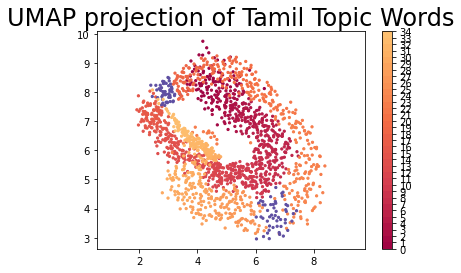

In [105]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=outlier_color,cmap='Spectral',s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(35)).set_ticks(np.arange(35))
plt.title('UMAP projection of Tamil Topic Words', fontsize=24)

In [50]:
## Embeddings 
text = "ஆந்திராவில்"
print(create_word_embeddings(text).shape)

torch.Size([1, 768])


In [52]:
topic_word_embdngs = []
for t in topic_words:
    topic_word_embdngs.append(get_topic_embeddings(t))

In [63]:
topic_word_embdngs[0][0].shape

torch.Size([1, 768])

In [79]:
embdngs.shape

(1700, 768)